Example workflow using pycaret, and Jimmy's "utility_forecast_analysis.ipynb"

Author: Hayden Fiege
Date: March 29 2021

In [1]:
import pandas as pd
import numpy as np
from math import log10
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook
from weather_scrape import *
from electricity_scrape import * 


Import weather_scrape.py and electricity_scrape.py files containing functions to scrape data

In [23]:
# weather params
city = 'yyc'
startdate = '2020-01-01'
enddate = '2020-12-31'
dateformat = '%Y-%m-%d'
contenttype = 'html'
#get raw data into pd dataframe, timeframe = 2 is daily data
weather_df  =  weather_dl_range(startdate, enddate, dateformat, city, 2, clean=True)

Getting data for YYC, station ID 50430
downloading daily data for year 2020
data for year 2020 downloaded
sleep for 5 seconds


Run function "aeso_download_range" to scrape electricity daily average pool prices for time range

In [60]:
#electricity params
tablename = 'DailyAveragePoolPrice'
startdate = '2020-01-01'
enddate = '2020-12-31'
dateformat = '%Y-%m-%d'
contenttype = 'html'
#get table of downloaded data, sort by date
util_prices = aeso_download_range(tablename, contenttype, startdate, enddate, dateformat).sort_values(by='$/MWh_Date').reset_index()

date range > 30 days, parse into 12 number of downloads
converted date string from 2020-01-01 00:00:00 to datetime value 01012020
converted date string from 2020-01-31 00:00:00 to datetime value 01312020
download url generated: http://ets.aeso.ca/ets_web/ip/Market/Reports/DailyAveragePoolPriceReportServlet?beginDate=01012020&endDate=01312020&contentType=html
2020-01-01 00:00:00downloaded
sleep for 7 seconds
converted date string from 2020-02-01 00:00:00 to datetime value 02012020
converted date string from 2020-03-02 00:00:00 to datetime value 03022020
download url generated: http://ets.aeso.ca/ets_web/ip/Market/Reports/DailyAveragePoolPriceReportServlet?beginDate=02012020&endDate=03022020&contentType=html
2020-02-01 00:00:00downloaded
sleep for 8 seconds
converted date string from 2020-03-03 00:00:00 to datetime value 03032020
converted date string from 2020-04-02 00:00:00 to datetime value 04022020
download url generated: http://ets.aeso.ca/ets_web/ip/Market/Reports/DailyAveragePoolP

Join weather data and electricity price data together for analysis

In [84]:
unseen_weather_df = weather_df.iloc[292:]
unseen_util_prices_df = util_prices.iloc[292:]
train_weather_df = weather_df.iloc[:292]
train_util_prices_df = util_prices.iloc[:292]

In [85]:
#join tables together
train_df = train_util_prices_df.merge(train_weather_df, how = 'left', left_on = '$/MWh_Date', right_on = 'Date/Time')
unseen_df = unseen_util_prices_df.merge(unseen_weather_df, how = 'left', left_on = '$/MWh_Date', right_on = 'Date/Time')

Pick Daily_Average as the price to analyze (predictor label), and convert to kwh for standard consumer units Define columns used for prediction label, features and timestamp

In [86]:
train_df['Avg_Price_kwh'] = train_df['Daily_Average'] / 1000
train_df = train_df.rename(columns = {'$/MWh_Date':'Date'})

unseen_df['Avg_Price_kwh'] = unseen_df['Daily_Average'] / 1000
unseen_df = unseen_df.rename(columns = {'$/MWh_Date':'Date'})

In [87]:
print(train_df.info())
print(unseen_df.info())

print(train_df.head())
print(unseen_df.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 291
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   index                      292 non-null    int64         
 1   Date                       292 non-null    datetime64[ns]
 2   Daily_Average              292 non-null    float64       
 3   Daily_On Peak Average      292 non-null    float64       
 4   Daily_Off Peak Average     292 non-null    float64       
 5   30Ravg_Average             292 non-null    float64       
 6   30Ravg_On Peak Average     292 non-null    float64       
 7   30Ravg_Off Peak Average    292 non-null    float64       
 8   Date/Time                  292 non-null    datetime64[ns]
 9   Month                      292 non-null    float64       
 10  Day                        292 non-null    int64         
 11  Max Temp (°C)              292 non-null    float64       
 12  Min Temp

In [88]:


train_df = train_df[['Date','Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
            'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
            'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)','Avg_Price_kwh']]
unseen_df = unseen_df[['Date','Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',
            'Heat Deg Days (°C)', 'Cool Deg Days (°C)', 'Total Rain (mm)',
            'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)',
            'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)','Avg_Price_kwh']]


In [89]:
dataset = train_df
#check the shape of data
dataset.shape

(292, 15)

In [90]:

data = dataset
data_unseen = unseen_df


print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (292, 15)
Unseen Data For Predictions: (74, 15)


In [91]:
from pycaret.regression import *
exp_reg101 = setup(data = data, target = 'Avg_Price_kwh', session_id=123)

,Description,Value
0,session_id,123
1,Target,Avg_Price_kwh
2,Original Data,"(292, 15)"
3,Missing Values,False
4,Numeric Features,13
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(204, 31)"


In [92]:
best = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,0.0223,0.0063,0.0609,-0.0447,0.0481,0.2739,0.0060
et,Extra Trees Regressor,0.0156,0.0012,0.0307,-0.3004,0.0261,0.3073,0.0290
rf,Random Forest Regressor,0.0144,0.0011,0.0292,-0.5763,0.0250,0.2906,0.0430
knn,K Neighbors Regressor,0.0216,0.0044,0.0533,-0.6437,0.0416,0.3336,0.0040
gbr,Gradient Boosting Regressor,0.0161,0.0014,0.0331,-0.9834,0.0282,0.3217,0.0120
ada,AdaBoost Regressor,0.0236,0.0009,0.0297,-1.1905,0.0261,0.6266,0.0100
en,Elastic Net,0.0334,0.0073,0.0685,-1.4079,0.0554,0.6549,0.0030
llar,Lasso Least Angle Regression,0.0334,0.0073,0.0686,-1.4138,0.0555,0.6585,0.0040
lasso,Lasso Regression,0.0334,0.0073,0.0686,-1.4138,0.0555,0.6585,0.0030
dt,Decision Tree Regressor,0.0176,0.0023,0.0380,-2.9147,0.0312,0.3263,0.0030


In [93]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
model_selected = "rf"

In [94]:
rf = create_model('rf')
print(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0085,0.0002,0.0127,-3.7947,0.0121,0.2878
1,0.0152,0.0009,0.0299,0.4054,0.0272,0.2193
2,0.0184,0.0012,0.0343,0.8958,0.0280,0.3057
3,0.0098,0.0003,0.0169,-0.4101,0.0162,0.2830
4,0.0122,0.0011,0.0329,-0.6250,0.0273,0.1964
5,0.0100,0.0003,0.0182,0.3098,0.0171,0.2671
6,0.0180,0.0010,0.0317,0.9482,0.0245,0.2717
7,0.0132,0.0007,0.0261,0.9658,0.0195,0.2776
8,0.0086,0.0003,0.0164,0.9831,0.0153,0.1863
9,0.0296,0.0053,0.0728,-5.4414,0.0627,0.6113


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


In [95]:
tuned_rf = tune_model(rf)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0037,0.0000,0.0048,0.2998,0.0047,0.1281
1,0.0188,0.0016,0.0401,-0.0730,0.0369,0.2473
2,0.0215,0.0025,0.0497,0.7814,0.0376,0.2394
3,0.0081,0.0002,0.0147,-0.0609,0.0140,0.1916
4,0.0130,0.0021,0.0457,-2.1369,0.0367,0.1642
5,0.0108,0.0005,0.0220,-0.0057,0.0205,0.2292
6,0.0324,0.0076,0.0873,0.6079,0.0625,0.2083
7,0.0281,0.0079,0.0890,0.6029,0.0615,0.3018
8,0.0261,0.0058,0.0762,0.6344,0.0544,0.2447
9,0.0195,0.0017,0.0412,-1.0629,0.0377,0.3822


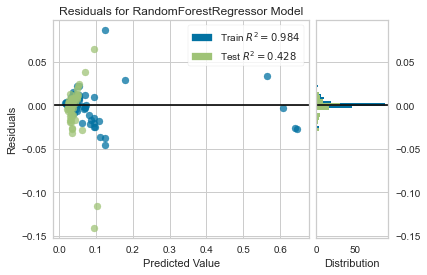

In [96]:
plot_model(rf)

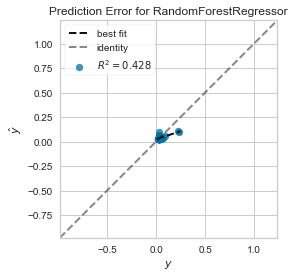

In [97]:
plot_model(rf, plot = 'error')

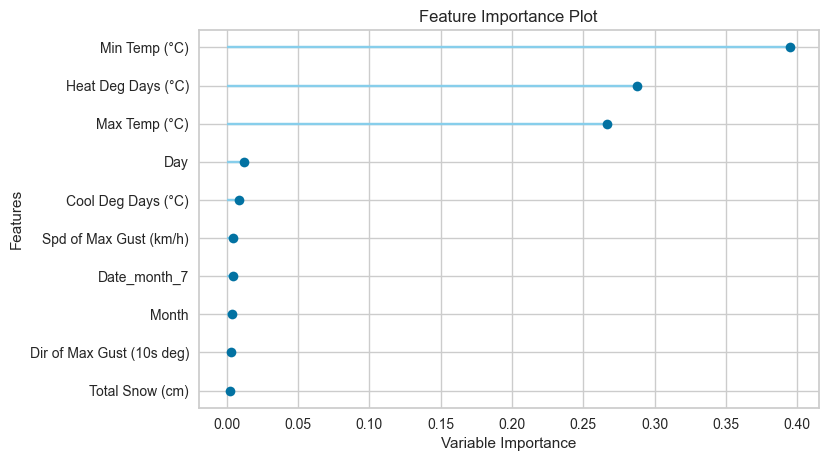

In [98]:
plot_model(rf, plot = 'feature')

In [99]:
predict_model(rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0104,0.0005,0.0232,0.4276,0.0206,0.2172


,Month,Day,Max Temp (°C),Min Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),...,Date_weekday_1,Date_weekday_2,Date_weekday_3,Date_weekday_4,Date_weekday_5,Date_weekday_6,Date_is_month_end_0,Date_is_month_start_0,Avg_Price_kwh,Label
0,7.0,12.0,21.100000,10.500000,2.200000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.02174,0.027724
1,5.0,22.0,5.300000,2.900000,13.900000,0.0,17.5,0.0,17.5,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.01752,0.030818
2,2.0,1.0,11.100000,-5.200000,15.000000,0.0,0.2,5.0,5.2,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.02927,0.051660
3,9.0,27.0,16.700001,6.500000,6.400000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.03380,0.031425
4,2.0,11.0,5.000000,-8.400000,19.700001,0.0,0.0,0.0,1.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.02982,0.032954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2.0,4.0,0.500000,-18.299999,26.900000,0.0,0.0,0.0,0.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.03107,0.037656
84,2.0,25.0,0.600000,-13.200000,24.299999,0.0,0.0,0.0,0.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.03344,0.046463
85,6.0,28.0,14.500000,8.300000,6.600000,0.0,14.5,0.0,14.5,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.02386,0.026554
86,5.0,17.0,21.600000,6.000000,4.200000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.03059,0.030503


In [100]:

final_rf = finalize_model(rf)

In [101]:
unseen_predictions = predict_model(final_rf, data=data_unseen)
unseen_predictions.head()

,Date,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow on Grnd (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),Avg_Price_kwh,Label
0,2020-10-19,10.0,19,-0.5,-8.0,-4.3,22.3,0.0,0.0,2.2,1.8,3.0,1.0,50.0,0.04711,0.066573
1,2020-10-20,10.0,20,1.9,-4.6,-1.4,19.4,0.0,0.0,0.6,0.6,4.0,35.0,48.0,0.06004,0.060869
2,2020-10-21,10.0,21,-2.6,-9.1,-5.9,23.9,0.0,0.0,2.6,2.2,4.0,2.0,46.0,0.05077,0.066030
3,2020-10-22,10.0,22,-8.1,-10.0,-9.1,27.1,0.0,0.0,2.4,0.8,5.0,0.0,0.0,0.29324,0.095824
4,2020-10-23,10.0,23,-9.0,-11.8,-10.4,28.4,0.0,0.0,7.6,4.4,6.0,8.0,33.0,0.14887,0.084172


<AxesSubplot:>

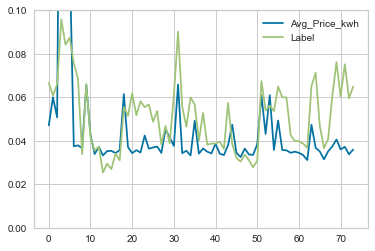

In [106]:
%matplotlib inline
unseen_predictions_label = unseen_predictions[['Avg_Price_kwh','Label']]
unseen_predictions_label.plot(ylim=[0,0.10])

In [107]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.Avg_Price_kwh, unseen_predictions.Label, 'R2')

0.2654

In [108]:
save_model(final_gbr,'Final rf Model 28Mar2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[],
                                       target='Avg_Price_kwh',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_st...
                                            learning_rate=0.1, loss='ls',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_de